### Binary Classification


In [33]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as op
from xgboost import train

from Info import features
from helper_functions import plot_decision_boundary

samples = 1000
X, y = make_circles(samples, noise=0.03, random_state=42)

In [34]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [35]:
# Create a DataFrame
circles = pd.DataFrame({'X1' : X[:, 0], 'X2' : X[:, 1], 'Lable' : y})
circles

,X1,X2,Lable
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


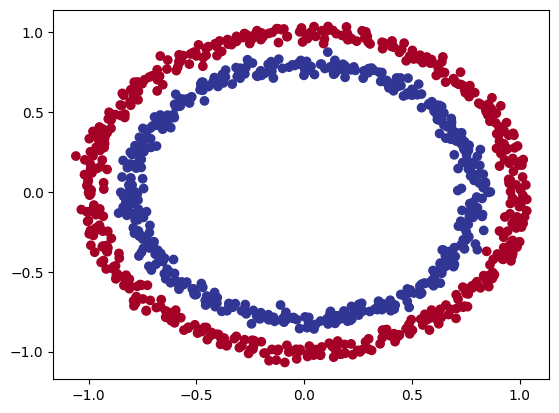

In [36]:
plt.scatter(circles.X1, circles.X2, c=y, cmap=plt.cm.RdYlBu)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tensor_X = torch.from_numpy(X).type(torch.float32)
tensor_y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test  = train_test_split(tensor_X ,tensor_y ,test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [38]:
class Classification(nn.Module):
    def __init__(self ,size, output):
        super().__init__()
        self.linear1 = nn.Linear(size, 10)
        self.linear2 = nn.Linear(10, 4)
        self.linear3 = nn.Linear(4, output)

    def forward(self, x):
        return self.linear3(torch.relu(self.linear2(torch.relu(self.linear1(x)))))
    
model = Classification(2,1).to(device)
optimizer = op.Adam(model.parameters(), lr=0.001)
loss_fun = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Sigmoid function inside

In [39]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() = compare two tensors
    acc = (correct / len(y_pred)) * 100
    return acc

In [40]:
torch.manual_seed(2)
epochs = 1000

for i in range(epochs):
    model.train()

    y_logit = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logit))  # Convert 1 if value >= 0.5 else 0

    loss = loss_fun(y_logit, y_train)
    acc = accuracy(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)

    if i % 100 == 0:
        print(
            f"Epoch: {epochs} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 1000 | Loss: 0.69279, Accuracy: 49.88% | Test loss: 0.69139, Test acc: 53.00%
Epoch: 1000 | Loss: 0.68826, Accuracy: 52.12% | Test loss: 0.68613, Test acc: 54.00%
Epoch: 1000 | Loss: 0.67718, Accuracy: 60.75% | Test loss: 0.67352, Test acc: 60.50%
Epoch: 1000 | Loss: 0.65811, Accuracy: 59.75% | Test loss: 0.65189, Test acc: 62.50%
Epoch: 1000 | Loss: 0.62352, Accuracy: 69.62% | Test loss: 0.62688, Test acc: 70.00%
Epoch: 1000 | Loss: 0.57130, Accuracy: 88.25% | Test loss: 0.58279, Test acc: 84.00%
Epoch: 1000 | Loss: 0.50598, Accuracy: 95.25% | Test loss: 0.52492, Test acc: 94.00%
Epoch: 1000 | Loss: 0.43501, Accuracy: 98.00% | Test loss: 0.46157, Test acc: 95.50%
Epoch: 1000 | Loss: 0.36338, Accuracy: 99.38% | Test loss: 0.39481, Test acc: 97.00%
Epoch: 1000 | Loss: 0.30187, Accuracy: 99.62% | Test loss: 0.33544, Test acc: 98.00%


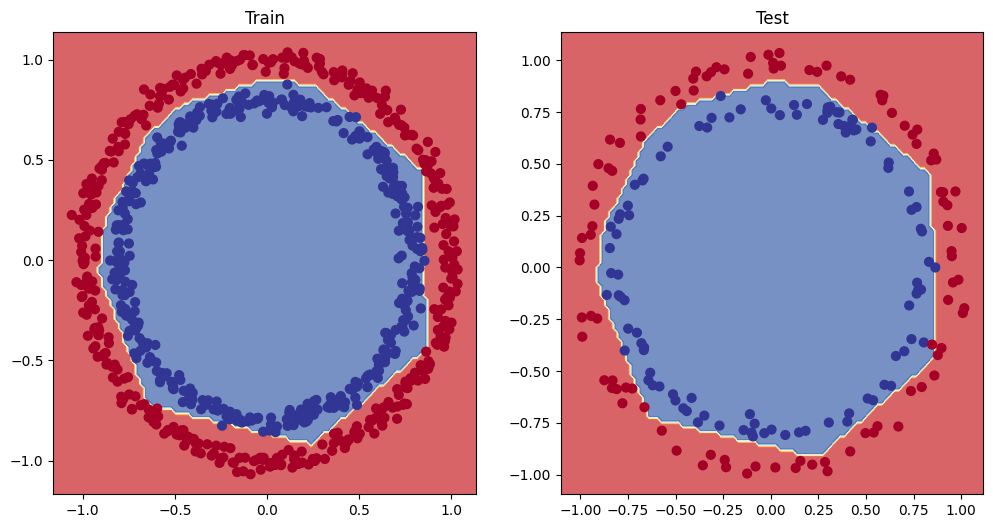

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()

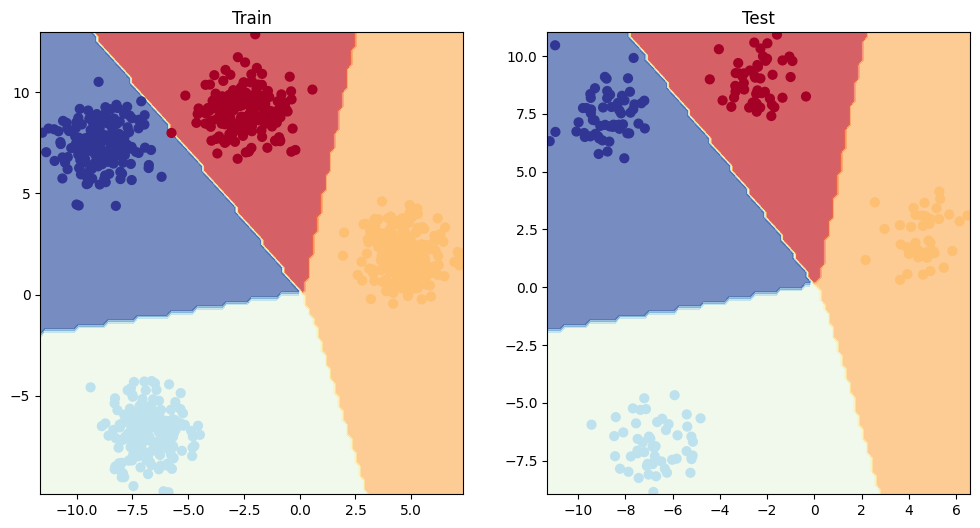

In [44]:
classes = 4
features = 2

X_blob, y_blob = make_blobs(n_samples=1000, centers=classes, n_features=features, random_state=42)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

class BlobClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(features, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = BlobClassification().to(device)
optimizer = op.Adam(model.parameters(), lr=0.01)
loss_fun = nn.CrossEntropyLoss()

torch.manual_seed(42)

epochs = 100
for i in range(epochs):
    model.train()

    y_logit = model(X_train.to(device))
    y_pred = torch.softmax(y_logit, dim=1)

    loss = loss_fun(y_logit, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fun(test_logits, y_test)

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()